<a href="https://colab.research.google.com/github/AyalSwaid/BookRecSys/blob/main/Copy_of_recSysNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and unzip datasets

In [1]:
with open("kaggle.json", "w") as file:
    file.write('{"username":"ayalsweed","key":"256c319bd85d5f872b0a7f47d2b522da"}')

!mkdir ../root/.kaggle
!cp kaggle.json ../root/.kaggle
!chmod 600 ../root/.kaggle/kaggle.json

### Goodread dataset

In [2]:
!echo "downloading"
!kaggle datasets download -d arashnic/book-recommendation-dataset
!echo "unzipping"
!unzip -n "book-recommendation-dataset.zip" -d "./goodreads"
!rm "book-recommendation-dataset.zip"
!echo "done"

downloading
 38% 9.00M/23.8M [00:00<00:00, 29.0MB/s]
100% 23.8M/23.8M [00:00<00:00, 62.7MB/s]
unzipping
Archive:  book-recommendation-dataset.zip
  inflating: ./goodreads/Books.csv   
  inflating: ./goodreads/Ratings.csv  
  inflating: ./goodreads/Users.csv   
  inflating: ./goodreads/recsys_taxonomy2.png  
done


### Amazon kindle dataset - 3.04 GB

In [3]:
!echo "downloading"
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!echo "unzipping"
!unzip -n "amazon-books-reviews.zip" -d "./amazon"
!rm "amazon-books-reviews.zip"
!echo "done"

downloading
 99% 1.05G/1.06G [00:11<00:00, 89.2MB/s]
100% 1.06G/1.06G [00:11<00:00, 97.8MB/s]
unzipping
Archive:  amazon-books-reviews.zip
  inflating: ./amazon/Books_rating.csv  
  inflating: ./amazon/books_data.csv  
done


# imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Goodreads EDA & processing

## EDA

In [75]:
# read datasets
ratings = pd.read_csv("./goodreads/Ratings.csv")
ratings = ratings.rename(columns = {'Book-Rating':'rating', 'User-ID': 'userID'})
users = pd.read_csv("./goodreads/Users.csv")
books = pd.read_csv("./goodreads/Books.csv")



<ipython-input-75-a7366e5b485f>:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("./goodreads/Books.csv")


In [76]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   userID  1149780 non-null  int64 
 1   ISBN    1149780 non-null  object
 2   rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [8]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


### Drop unnecessery columns

In [9]:
books.drop(["Image-URL-S", "Image-URL-M", "Image-URL-L"], axis=1, inplace=True)

### Ratings distribution

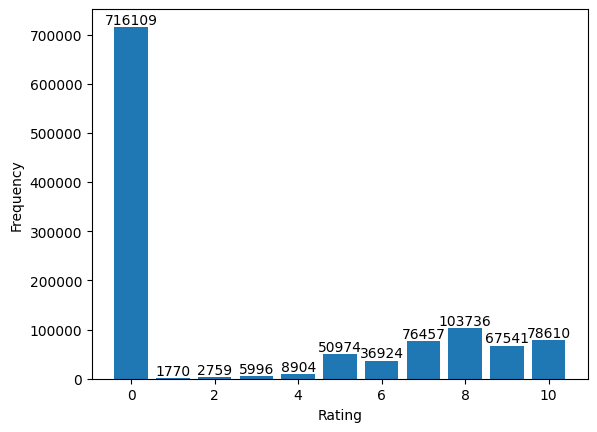

In [77]:
def show_ratings_dist(df, col="rating", user_col="userID"):
    rating_dist = df.groupby([col]).count().reset_index()
    # rating_dist
    # plt.bar(rating_dist["rating"].values,rating_dist["userID"])

    fig, ax = plt.subplots()
    bars = ax.bar(rating_dist[col].values, rating_dist[user_col])
    ax.set_xlabel("Rating")
    ax.set_ylabel("Frequency")
    ax.bar_label(bars)
show_ratings_dist(ratings)

normalize rating to max 5

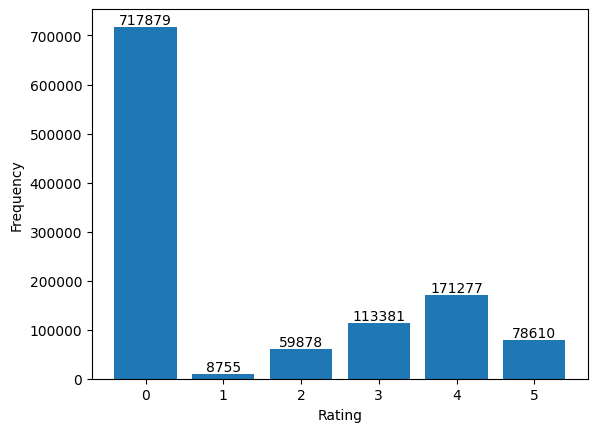

In [78]:
# r = ratings.copy()
ratings["rating"] = ratings["rating"].apply(lambda e: e//2)
show_ratings_dist(ratings)

In [12]:
ratings["rating"].values

array([0, 2, 0, ..., 5, 5, 4])

STANDARDIZATION TEST

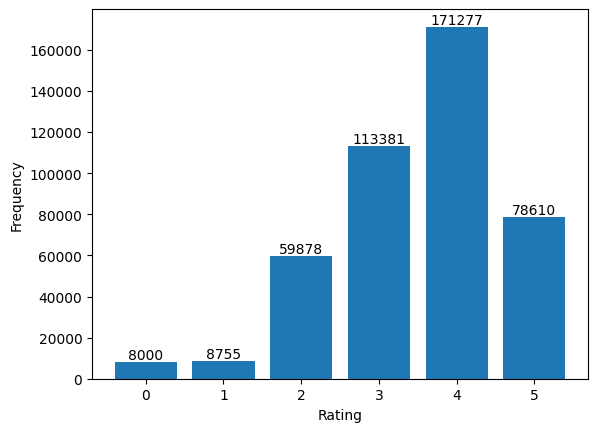

In [13]:
# from sklearn import preprocessing

# x = ratings["rating"].values.reshape(-1,1) #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# ratings["norm_rating"] = min_max_scaler.fit_transform(x)
# show_ratings_dist(ratings, "norm_rating")

zeros = ratings[ratings['rating'] == 0].sample(n=8000, random_state=1)
ratings_test = ratings[ratings['rating'] != 0]
ratings = pd.concat([ratings_test, zeros], axis=0)

show_ratings_dist(ratings, "rating")

# Amazon dataset EDA & processing

## EDA


### Read df info

In [59]:
a_ratings = pd.read_csv("./amazon/Books_rating.csv")

In [60]:
a_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB


In [61]:
a_ratings.drop(["review/text", "review/summary", "review/time", "review/helpfulness", "profileName"], axis=1, inplace=True)

### Check nulls

In [17]:
a_ratings.isnull().sum()

Id                    0
Title               208
Price           2518829
User_id          561787
review/score          0
dtype: int64

drop nulls from user_id and title

In [62]:
a_ratings.dropna(subset = ["User_id", "Title"], inplace=True)

### ratings dist

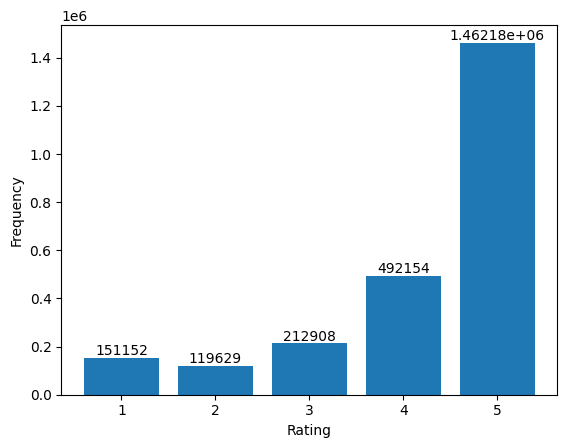

In [19]:
show_ratings_dist(a_ratings, "review/score", "User_id")

In [20]:
# filtered_ratings = a_ratings.groupby('User_id').count()['review/score'] > 100
# filtered_users = filtered_ratings[filtered_ratings].index

# filtered_ratings = a_ratings[a_ratings["User_id"].isin(filtered_users)]
# filtered_ratings.info()

In [ ]:
# show_ratings_dist(filtered_ratings, "review/score", "User_id")

# Merge Datasets

### Add book ISBN column according to goodreads dataset

In [79]:
# Build dict to map book title to ISBN
titles_dict = {}


def build_dict(r):
    titles_dict[r["Book-Title"]] = r["ISBN"]
    return None

books.apply(axis=1, func= build_dict)

counter = 0
# Add the ISBN column according to the dict
def func(e):
    global counter

    # create custom ISBN for books that has no ISBN in the goodreads dataset
    ISBN = titles_dict.get(e,  f"custom{counter}")
    counter += 1
    # if ISBN is None:
    #     ISBN =
    return ISBN

a_ratings["ISBN"] = a_ratings["Title"].apply(func)

### Take only userID, ISBN and rating columns from amazon dataset

In [80]:
newa_ratings = a_ratings[["User_id", "ISBN", "review/score"]]
newa_ratings = newa_ratings.rename(columns = {"review/score": "rating", "User_id": "userID"})
newa_ratings.head()

,userID,ISBN,rating
0,AVCGYZL8FQQTD,custom0,4.0
1,A30TK6U7DNS82R,custom1,5.0
2,A3UH4UZ4RSVO82,custom2,5.0
3,A2MVUWT453QH61,custom3,4.0
4,A22X4XUPKF66MR,custom4,4.0


### Change userID prefix in gr dataset to start with 'gr'
We do this to prevent conflicts between users with the same id from different datasets

In [81]:
ratings["userID"] = ratings["userID"].apply(lambda e: 'gr'+str(e))
ratings.head()

,userID,ISBN,rating
0,gr276725,034545104X,0
1,gr276726,0155061224,2
2,gr276727,0446520802,0
3,gr276729,052165615X,1
4,gr276729,0521795028,3


### Contacate the datasets

In [82]:
final_df = pd.concat([ratings, newa_ratings], axis=0,
                               verify_integrity=True, # Verifies duplicate entries
                        ignore_index=True, # Retain index of source dfs
                        )

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3587798 entries, 0 to 3587797
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   userID  object 
 1   ISBN    object 
 2   rating  float64
dtypes: float64(1), object(2)
memory usage: 82.1+ MB


### Test that result makes sense

In [83]:
assert ratings["userID"].str.startswith("gr").sum()
assert final_df.shape[0] == (ratings.shape[0] + newa_ratings.shape[0])

### Show ratings dist of the merged dataset

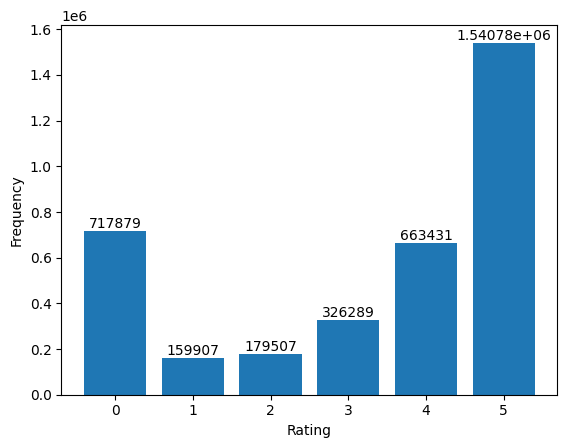

In [84]:
show_ratings_dist(final_df)

# Build matrix factorization model



In [70]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163766 sha256=7139d0997ef5bb2f495bd966a2c3cf59fe979ee33b7c17c91c3f031aa28a22c8
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [85]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.similarities import cosine

reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(final_df[['userID', 'ISBN', 'rating']], reader)



Hyper parameter tuning


In [87]:
svd = SVD(n_epochs=30)
param_grid = {'n_factors': [128],
              'lr_all': [0.01]}

for nf in param_grid["n_factors"]:
    for ra in param_grid["lr_all"]:
        print(f"\n\nTrying n_factors={nf}, reg_all={ra}")
        cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

# grid_search = GridSearchCV(svd, param_grid, measures=['rmse', 'mae'], cv=3)
# grid_search.fit(data)



Trying n_factors=128, reg_all=0.01
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3984  1.3993  1.3994  1.3990  0.0004  
MAE (testset)     1.1675  1.1679  1.1685  1.1680  0.0004  
Fit time          136.51  174.41  144.11  151.68  16.37   
Test time         18.79   22.64   20.94   20.79   1.58    


Fit the model

In [88]:
svd = SVD(n_epochs=30, n_factors=32)
train_data = data.build_full_trainset()
svd.fit(train_data)



In [ ]:
np.max([svd.predict(9461, i).est for i in books["ISBN"].values])

3.868600871663047

### Find similar users.
We can use the users embeddings and find the most similar users to a specific user using cosine similarity

In [89]:
item_matrix = svd.qi
user_matrix = svd.pu
from sklearn.metrics.pairwise import cosine_similarity
# sorted([cosine_similarity(user_matrix, user_matrix.T) for i in range(1,user_matrix.shape[0])])
# cosine_similarity(user_matrix[2])
# sim_mat = cosine_similarity([user_matrix[0]], [user_matrix[1]])
# sim_mat

def top_N_sim_users(raw_uid, user_matrix, N=10):
    inner_uid = svd.trainset.to_inner_uid(raw_uid)
    sim_mat = cosine_similarity([user_matrix[inner_uid]], user_matrix)[0]
    sim_dict = {i:sim_mat[i] for i in range(user_matrix.shape[0])}
    top_N = sorted(sim_dict.items(), reverse=True, key=lambda e: e[1])[:N+1]
    top_N = {svd.trainset.to_raw_uid(inner_uid):sim for (inner_uid,sim) in top_N}
    return top_N

top_N_sim_users(raw_uid=78313, N=10, user_matrix=user_matrix)


ValueError: ignored

### Find close books to this user
Note: Users and books are in the same embedding space, therefore we can find books embeddings that are close to a specific **user**

In [ ]:
def find_N_sim_books_to_user(raw_uid, user_mat, book_mat, N=10):
    inner_uid = svd.trainset.to_inner_uid(raw_uid)
    sim_mat = cosine_similarity([user_mat[inner_uid]], book_mat)[0]
    sim_dict = {i:sim_mat[i] for i in range(book_mat.shape[0])}# TODO: u can use list of tuples instead of dict
    top_N = sorted(sim_dict.items(), reverse=True, key=lambda e: e[1])[:N+1]
    top_N = {svd.trainset.to_raw_iid(inner_iid):sim for (inner_iid,sim) in top_N}
    return top_N


find_N_sim_books_to_user(raw_uid=230, user_mat=user_matrix, book_mat=item_matrix, N=10)

{'0843770554': 0.6836632268768745,
 '0590462245': 0.6664727306025591,
 '0899193145': 0.6521659171438319,
 '0618042474': 0.6521444840177438,
 '0671507915': 0.6487852379508994,
 '8807814633': 0.648302887111077,
 '0552125245': 0.6359850015314988,
 '0766789780': 0.6214605882253302,
 '8820028638': 0.6190062075758905,
 '0679726802': 0.6150101053658782,
 '0679754342': 0.6083168143773864}

### Find similar books to a specific book according to the SVD embedding

In [ ]:
def find_N_sim_books(raw_iid, book_mat, N=10):
    inner_iid = svd.trainset.to_inner_iid(raw_iid)
    sim_mat = cosine_similarity([book_mat[inner_iid]], book_mat)[0]
    sim_dict = {i:sim_mat[i] for i in range(book_mat.shape[0])}# TODO: u can use list of tuples instead of dict
    top_N = sorted(sim_dict.items(), reverse=True, key=lambda e: e[1])[:N+1]
    top_N = {svd.trainset.to_raw_iid(inner_iid):sim for (inner_iid,sim) in top_N}
    return top_N


find_N_sim_books(raw_iid="0451145577", book_mat=item_matrix, N=10)

{'0451145577': 1.0000000000000002,
 '1566190541': 0.6938491898526227,
 '1862075964': 0.6802969720585887,
 '1563410443': 0.6642573570121294,
 '0373078897': 0.6563878887618936,
 '8845916758': 0.6490411923683617,
 '0801042968': 0.6456940842505798,
 '1570424993': 0.642564908426491,
 '0590298402': 0.639111819133861,
 '0671014234': 0.6383617512402584,
 '0142001570': 0.6343198813131835}

some tests, delete later

In [ ]:
books[books["ISBN"] == "076111730X"]
books[books["ISBN"] == "0451145577"]
# books.sample()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
13768,0451145577,The Seventh Secret,Irving Wallace,1986,Signet Book,http://images.amazon.com/images/P/0451145577.0...,http://images.amazon.com/images/P/0451145577.0...,http://images.amazon.com/images/P/0451145577.0...


<BarContainer object of 5 artists>

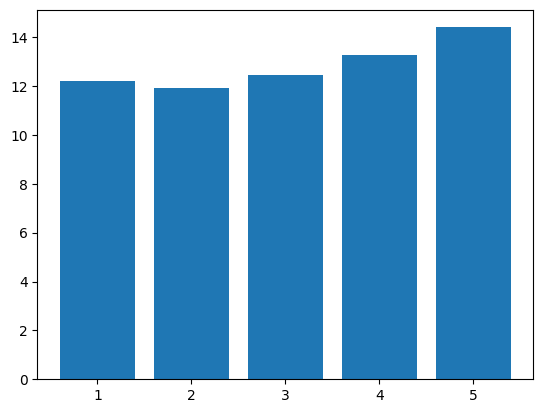

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dist = {5: np.log(1800000),
        4: np.log(585000),
        3:np.log(254000),
        2:np.log(151000),
        1:np.log(200000)}


dist = {np.log(5): 1800000,
        np.log(4): 585000,
        np.log(3):254000,
        np.log(2):151000,
        np.log(1):200000}

plt.bar(dist.keys(), dist.values())

In [ ]:
ratings.groupby('userID').count()


,ISBN,rating
userID,,
2,1,1
7,1,1
8,18,18
9,3,3
10,2,2
...,...,...
278846,2,2
278849,4,4
278851,23,23
